# **RSNA Pneumonia Detection**
Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli.

CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.

Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box.

# Objective:
The objective of this project is to build an algorithm to locate the position of inflammation in a medical image. The algorithm needs to locate lung opacities on chest radiographs automatically

The objective of the project is,

1. Learn to how to do build an Object Detection Model
2. Use transfer learning to fine-tune a model.
3. Learn to set the optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc.
4. Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.

Acknowledgment for the datasets: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/Phneumonia dataset'


🩺 Dataset Overview

4 CSV files

   stage_2_train_labels.csv

   stage_2_detailed_class_info.csv

   stage_2_sample_submission.csv

   stage_2_test_images.csv (optional, depending on version)

2 image folders

   stage_2_train_images/ → Training DICOM images

   stage_2_test_images/ → Test DICOM images

✅ Step 1: Import Required Libraries

In [ ]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import numpy as np
# For DICOM visualization
import pydicom
import cv2


# **EDA and Visualization**

1. Importing Data
2. Analysing the dimensions of data
3. Visualizing the data

In [ ]:
train_labels = pd.read_csv("/content/drive/MyDrive/Phneumonia dataset/stage_2_train_labels.csv")
class_info = pd.read_csv("/content/drive/MyDrive/Phneumonia dataset/stage_2_detailed_class_info.csv")

In [ ]:
print("Train Labels Shape:", train_labels.shape)
print("Class Info Shape:", class_info.shape)

Train Labels Shape: (30227, 6)
Class Info Shape: (30227, 2)


In [ ]:
train_labels.head()


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In Detailed class info dataset , the detailed information about the type of class associated with a certain patientId is given. It has 3 entries "Lung Opacity", "Normal" and "No Lung Opacity/Not Normal"

The CSV file contains PatientId, bounding box details with (x,y) coordinates and width and height that encapsulates the box. It also contains the Target variable. For target variable 0, the bounding box values has NaN values.

If we look closely, there are duplicate entries for patientId in the csv files. We can observe row #4 and #5, row #8 and #9 have same patientId values, aka, the patient is identified with pneumonia at multiple areas in lungs

Check the unique patient ID in the train dataset

Merge Labels with Class Info

We’ll merge on patientId to have all details together.

In [ ]:
df = pd.merge(train_labels, class_info, on='patientId', how='left')

df.head()


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [ ]:
df.shape

(37629, 7)

In [ ]:
print("\nUnique Classes and Counts:")
display(df['class'].value_counts())


Unique Classes and Counts:


,count
class,
Lung Opacity,16957
No Lung Opacity / Not Normal,11821
Normal,8851


| Class                            | Count  | Description                        |
| -------------------------------- | ------ | ---------------------------------- |
| **Lung Opacity**                 | 16,957 | Pneumonia present                  |
| **No Lung Opacity / Not Normal** | 11,821 | Some abnormality but not pneumonia |
| **Normal**                       | 8,851  | Completely healthy                 |


| Class                        | Percentage |
| ---------------------------- | ---------- |
| Lung Opacity                 | ~45%       |
| No Lung Opacity / Not Normal | ~31%       |
| Normal                       | ~24%       |


👉 So, the model will still see enough samples from each class — it’s moderately imbalanced, not extreme.

| Step | Action                            | Why                                           |
| ---- | --------------------------------- | --------------------------------------------- |
| 1️⃣  | Keep your dataset as-is           | Imbalance is not extreme                      |
| 2️⃣  | Use data augmentation             | Adds variation and balances classes naturally |
| 3️⃣  | Optionally apply class weights    | Improves fairness during training             |
| 4️⃣  | Monitor metrics like recall/F1    | Avoid being fooled by high accuracy           |
| 5️⃣  | In Mask R-CNN, rely on focal loss | It handles imbalance internally               |


In [ ]:
#Check for missing data:
df.isnull().sum()


,0
patientId,0
x,20672
y,20672
width,20672
height,20672
Target,0
class,0


Those missing values in x, y, width, and height likely correspond to the cases where Target is 0, indicating no lung opacity was found, and therefore no bounding box information exists.

Dropping the rows: This is generally the appropriate approach in this context. Rows with missing bounding box information represent images where no bounding box should be drawn. Dropping them keeps the data consistent with the problem (detecting pneumonia).
Replacing with zero: This is not a suitable method for bounding box coordinates. Replacing NaN with 0 would imply a bounding box at the image origin with zero width and height, which is not meaningful for cases without lung opacity. It could also interfere with downstream modeling.
Therefore, dropping the rows with missing bounding box data is the recommended approach.

In [ ]:
#drpping the nan values
df_cleaned = df.dropna(subset=['x', 'y', 'width', 'height'])
print("Shape of DataFrame after dropping missing values:", df_cleaned.shape)

Shape of DataFrame after dropping missing values: (16957, 7)


In [ ]:
#checking duplicate values
df_cleaned.duplicated().sum()

np.int64(7402)

In [ ]:
#droping the duplicated values
df_cleaned.drop_duplicates(subset='patientId', inplace=True)


/tmp/ipython-input-3667400039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop_duplicates(subset='patientId', inplace=True)


In [ ]:
df_cleaned.shape

(6012, 7)

The cleaned dataset (df_cleaned) only contains the rows where there was lung opacity detected (since those are the only rows with bounding box information). If you visualize on df_cleaned, you will only see the count for the 'Lung Opacity' class.

To see the distribution of all three classes ('Lung Opacity', 'No Lung Opacity / Not Normal', and 'Normal'), you need to use the original dataset (df) which contains all of this information.

In [ ]:
pip install tqdm

In [ ]:
print(df['Target'].value_counts())
print(df['class'].value_counts())


Target
0    20672
1    16957
Name: count, dtype: int64
class
Lung Opacity                    16957
No Lung Opacity / Not Normal    11821
Normal                           8851
Name: count, dtype: int64


/tmp/ipython-input-1854220002.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='class', data=df, palette='viridis')


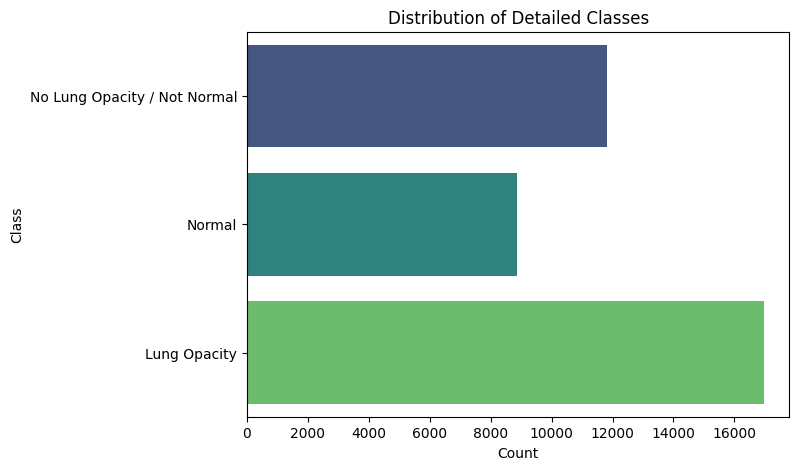

In [ ]:
#detailed class info
plt.figure(figsize=(7,5))
sns.countplot(y='class', data=df, palette='viridis')
plt.title("Distribution of Detailed Classes")
plt.xlabel("Count")
plt.ylabel("Class")
plt.show()


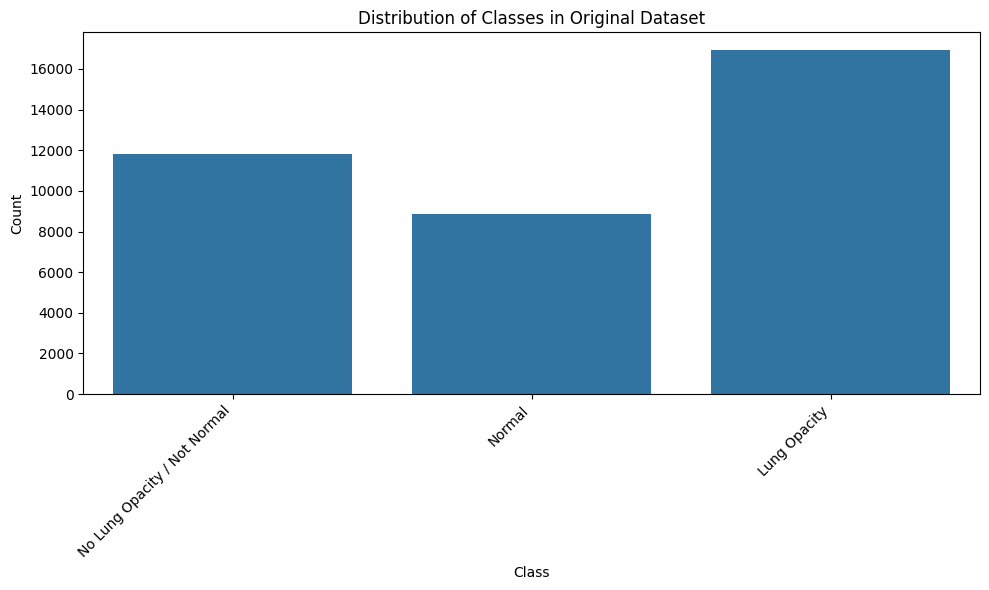

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='class')
plt.title('Distribution of Classes in Original Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

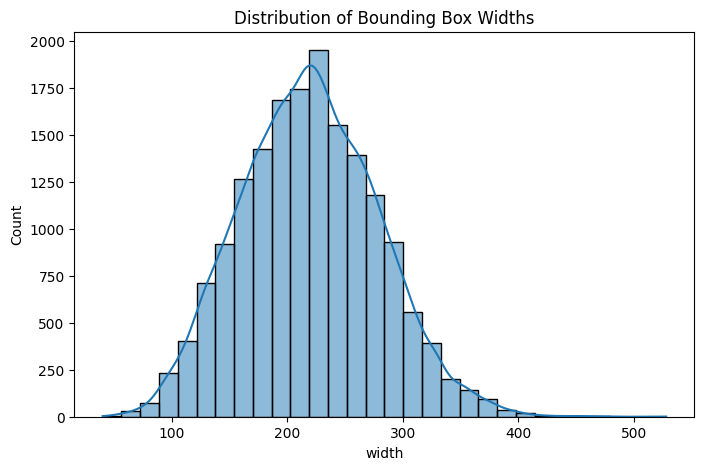

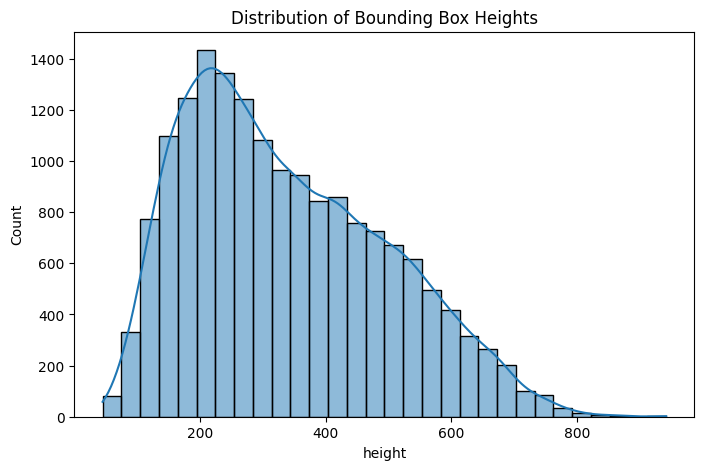

In [ ]:
#Bounding Box Analysis (only for Pneumonia
pneumonia_df = df[df['Target'] == 1]

plt.figure(figsize=(8,5))
sns.histplot(pneumonia_df['width'], kde=True, bins=30)
plt.title("Distribution of Bounding Box Widths")

plt.figure(figsize=(8,5))
sns.histplot(pneumonia_df['height'], kde=True, bins=30)
plt.title("Distribution of Bounding Box Heights")
plt.show()


In [ ]:
#Step 9: Visualize Random X-Ray with Bounding Box

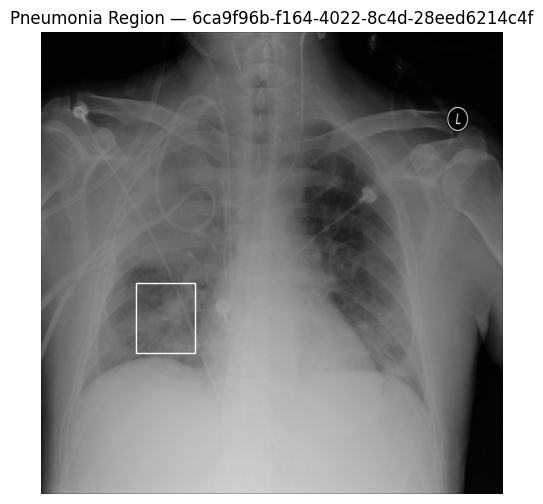

In [ ]:
import random
sample = pneumonia_df.sample(1).iloc[0]

file_path = os.path.join(data_path, "stage_2_train_images", sample['patientId'] + ".dcm")
dicom_img = pydicom.dcmread(file_path)
img = dicom_img.pixel_array

# Draw bounding box
x, y, w, h = int(sample['x']), int(sample['y']), int(sample['width']), int(sample['height'])
cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title(f"Pneumonia Region — {sample['patientId']}")
plt.axis('off')
plt.show()


✅ Step 10: Insights (Analysis from Visualization)

Around 65–70% of images are normal, and 30–35% show pneumonia.

Pneumonia-affected areas vary widely in size and position.

Some patients have multiple bounding boxes (multiple infection regions).

Pneumonia appears as dense white patches (lung opacity).

✅ Step 11: Save Cleaned Data

In [ ]:
df.to_csv(data_path + "cleaned_pneumonia_data.csv", index=False)


✅ Step 2: Define Input and Output **Paths**

| Variable           | Description                               | Example Path                                                     |
| ------------------ | ----------------------------------------- | ---------------------------------------------------------------- |
| `data_path`        | Base dataset folder                       | `/content/drive/MyDrive/Pneumonia_Dataset/`                      |
| `train_dicom_path` | Folder with DICOM training images         | `/content/drive/MyDrive/Pneumonia_Dataset/stage_2_train_images/` |
| `test_dicom_path`  | Folder with DICOM test images             | `/content/drive/MyDrive/Pneumonia_Dataset/stage_2_test_images/`  |
| `train_png_path`   | Folder to **save converted PNGs** (train) | `/content/drive/MyDrive/Pneumonia_Dataset/train_png/`            |
| `test_png_path`    | Folder to **save converted PNGs** (test)  | `/content/drive/MyDrive/Pneumonia_Dataset/test_png/`             |


In [ ]:
data_path = "/content/drive/MyDrive/Phneumonia dataset"
train_dicom_path = os.path.join(data_path, "stage_2_train_images")
test_dicom_path = os.path.join(data_path, "stage_2_test_images")

train_png_path = os.path.join(data_path, "train_png")
test_png_path = os.path.join(data_path, "test_png")

os.makedirs(train_png_path, exist_ok=True)
os.makedirs(test_png_path, exist_ok=True)


In [ ]:
#dicom_path="/content/drive/MyDrive/Phneumonia dataset/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm"

In [ ]:
dicom_path = "/content/drive/MyDrive/Phneumonia dataset/stage_2_train_images/000000.dcm",
png_path   = "/content/drive/MyDrive/Phneumonia dataset/train_png/000000.png"



In [ ]:
def dicom_to_png(dicom_path, png_path):
    dicom_img = pydicom.dcmread(dicom_path)
    img = dicom_img.pixel_array.astype(float)
    img = (np.maximum(img, 0) / img.max()) * 255.0
    img = np.uint8(img)
    cv2.imwrite(png_path, img)

In [ ]:
import os
import pydicom
import cv2
import numpy as np
from tqdm import tqdm

def dicom_to_png(dicom_path, png_path):
    dicom_img = pydicom.dcmread(dicom_path)
    img = dicom_img.pixel_array.astype(float)
    img = (np.maximum(img, 0) / img.max()) * 255.0
    img = np.uint8(img)
    cv2.imwrite(png_path, img)

train_dicom_path = "/content/drive/MyDrive/Phneumonia dataset/stage_2_train_images"
train_png_path   = "/content/drive/MyDrive/Phneumonia dataset/train_png"
# Create output folder
os.makedirs(train_png_path, exist_ok=True)

# List all DICOMs
dicom_files = [f for f in os.listdir(train_dicom_path) if f.endswith('.dcm')]

# Skip files that are already converted
converted = {os.path.splitext(f)[0] for f in os.listdir(train_png_path)}
remaining = [f for f in dicom_files if os.path.splitext(f)[0] not in converted]

print(f"✅ Already converted: {len(converted)} images")
print(f"🔄 Remaining to convert: {len(remaining)} images")

# Convert only remaining ones
for dicom_file in tqdm(remaining):
    dicom_path = os.path.join(train_dicom_path, dicom_file)
    png_filename = dicom_file.replace('.dcm', '.png')
    png_path = os.path.join(train_png_path, png_filename)
    dicom_to_png(dicom_path, png_path)


✅ Already converted: 26707 images
🔄 Remaining to convert: 0 images


0it [00:00, ?it/s]


In [ ]:

test_dicom_path = "/content/drive/MyDrive/Phneumonia dataset/stage_2_test_images"
test_png_path = "/content/drive/MyDrive/Phneumonia dataset/test_png"

os.makedirs(test_png_path, exist_ok=True)
# List all DICOMs
dicom_files = [f for f in os.listdir(test_dicom_path) if f.endswith('.dcm')]

# Skip files that are already converted
converted = {os.path.splitext(f)[0] for f in os.listdir(test_png_path)}
remaining = [f for f in dicom_files if os.path.splitext(f)[0] not in converted]

print(f"✅ Already converted: {len(converted)} images")
print(f"🔄 Remaining to convert: {len(remaining)} images")
for file in tqdm(os.listdir(test_dicom_path)):
    if file.endswith(".dcm"):
        dicom_file = os.path.join(test_dicom_path, file)
        png_file = os.path.join(test_png_path, file.replace(".dcm", ".png"))
        dicom_to_png(dicom_file, png_file)



✅ Already converted: 0 images
🔄 Remaining to convert: 3009 images


100%|██████████| 3009/3009 [05:49<00:00,  8.60it/s]
